In [1]:
# Imports
from pinecone import Pinecone
from dotenv import load_dotenv
import os

/Users/eric/Desktop/CS 4675/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Initialize a Pinecone client with your API key
load_dotenv()
pineAPI = os.getenv("PINECONE_API")
pc = Pinecone(api_key=pineAPI)

In [4]:
# Create a dense index with integrated embedding
index_name = "dense-index"
if not pc.has_index(index_name):
    pc.create_index_for_model(
        name=index_name,
        cloud="aws",
        region="us-east-1",
        embed={
            "model":"llama-text-embed-v2",
            "field_map":{"text": "chunk_text"}
        }
    )

In [5]:
# Variables for parsing
num_docs = 0
labs  = ["lab0", "lab1", "lab2", "lab3"]
records = []


In [6]:
# parse documents
import os
import re
from typing import Dict, List, Optional

def parse_lab_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    question_match = re.search(r'Question:\s*(.*?)(?=Student Answer:|$)', content, re.DOTALL)
    student_answer_match = re.search(r'Student Answer:\s*(.*?)(?=Instructor Answer:|$)', content, re.DOTALL)
    instructor_answer_match = re.search(r'Instructor Answer:\s*(.*?)(?=Followup Discussions:|$)', content, re.DOTALL)
    followup_match = re.search(r'Followup Discussions:\s*(.*?)$', content, re.DOTALL)
    
    # Extract the content for each section, strip whitespace
    question = question_match.group(1).strip() if question_match else ""
    student_answer = student_answer_match.group(1).strip() if student_answer_match else ""
    instructor_answer = instructor_answer_match.group(1).strip() if instructor_answer_match else ""
    followups = followup_match.group(1).strip() if followup_match else ""
    
    # Create structured document
    return {
        "file_name": os.path.basename(file_path),
        "question": question,
        "student_answer": student_answer,
        "instructor_answer": instructor_answer,
        "followups": followups
    }

def process_lab_files(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            parsed_data = parse_lab_file(file_path)
            results.append(parsed_data)
    return results

def format_for_rag(parsed_data, category):
    global num_docs
    rag_documents = []
    
    for i, item in enumerate(parsed_data):
        doc_id = f"rec{num_docs}"
        num_docs += 1
        
        # Format text the same way as before
        formatted_text = f"""Question:{item['question']}
        Student Answer:{item['student_answer']}
        Instructor Answer:{item['instructor_answer']}
        Followup Discussions:{item['followups']}""".strip()
        
        # Create record dictionary
        record = {
            "_id": doc_id,
            "chunk_text": formatted_text,
            "category": category
        }
        
        rag_documents.append(record)
    
    return rag_documents

for lab in labs:
    cur_parsed = process_lab_files(lab)
    cur_raw_docs = format_for_rag(cur_parsed, lab)
    records.extend(cur_raw_docs)

print("Proccesed ", num_docs, "documents")


Proccesed  320 documents


In [7]:
batch_size = 96
dense_index = pc.Index(index_name)
for i in range(0, len(records), batch_size):
    batch = records[i:i+batch_size]
    dense_index.upsert_records("example-namespace", batch)
    print(f"Upserted batch {i//batch_size + 1} ({len(batch)} records)")

print(f"Total records upserted: {len(records)}")

Upserted batch 1 (96 records)
Upserted batch 2 (96 records)
Upserted batch 3 (96 records)
Upserted batch 4 (32 records)
Total records upserted: 320


In [8]:
stats = dense_index.describe_index_stats()
print(stats)

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'example-namespace': {'vector_count': 1060}},
 'total_vector_count': 1060,
 'vector_type': 'dense'}


[[-8.22448730e-03 -2.23236084e-02  9.05609131e-03 ...  5.43212891e-03
  -7.12585449e-03 -5.21850586e-02]
 [-2.53143311e-02  1.25961304e-02 -1.46408081e-02 ...  3.56750488e-02
   1.67999268e-02 -3.18603516e-02]
 [ 2.53295898e-02  2.87933350e-02 -2.07138062e-03 ... -2.46429443e-02
   3.68957520e-02  2.14576721e-05]
 ...
 [ 2.60162354e-02 -1.86920166e-02 -1.53446198e-03 ... -1.57165527e-02
   4.54711914e-02 -4.81872559e-02]
 [ 1.08489990e-02  2.67181396e-02  1.10702515e-02 ...  5.03921509e-03
  -2.46429443e-02 -4.19616699e-02]
 [ 1.34277344e-02 -3.55834961e-02 -3.70597839e-03 ... -1.24740601e-02
   5.29785156e-02  3.08990479e-02]]


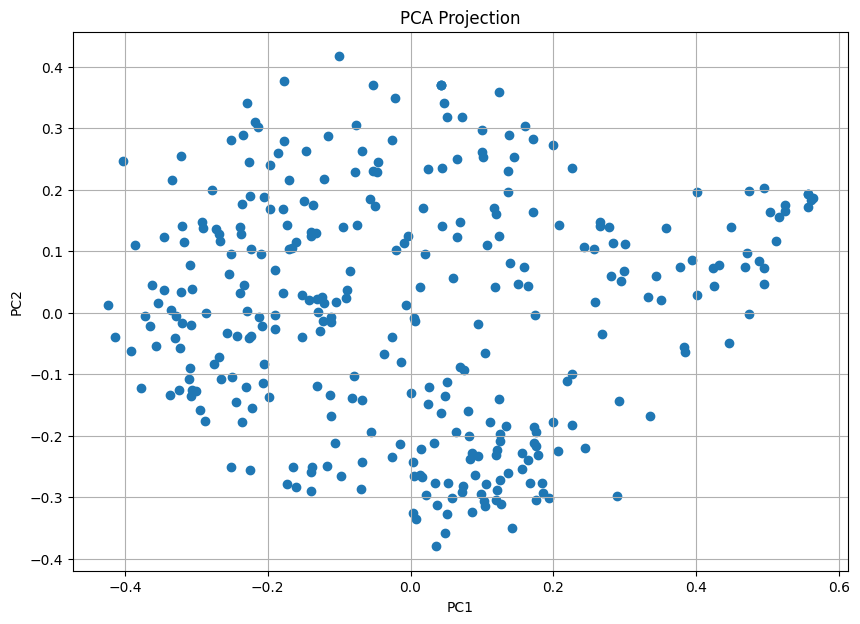

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

vector_ids = [f"rec{i}" for i in range(num_docs)]

vectors = []
fetched_ids = []

# Fetch in batches
for i in range(0, len(vector_ids), batch_size):
    batch_ids = vector_ids[i:i+batch_size]
    response = dense_index.fetch(namespace="example-namespace", ids=batch_ids)
    
    for vid, record in response.vectors.items():
        vectors.append(record.values)
        fetched_ids.append(vid)




vectors_np = np.array(vectors)

for i in vectors_np:
    print(i)

pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors_np)

plt.figure(figsize=(10, 7))
plt.scatter(reduced[:, 0], reduced[:, 1])
plt.title("PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [40]:
from pinecone.exceptions import PineconeApiException 
def ask_query(query, debug):
    try:

        results = dense_index.search(
            namespace="example-namespace",
            query={
                "top_k": 10,
                "inputs": {
                    'text': query
                }
            }
        )
        
        try:
            reranked_results = dense_index.search(
                namespace="example-namespace",
                query={
                    "top_k": 10,
                    "inputs": {
                        'text': query
                    }
                },
                rerank={
                    "model": "bge-reranker-v2-m3",
                    "top_n": 10,
                    "rank_fields": ["chunk_text"]
                }   
            )
            search_results = reranked_results
        except PineconeApiException as e:
            # If reranking fails due to token limits, fall back to regular search results
            if debug:
                print(f"Reranking failed: Using standard search results instead.")
            search_results = results
            
        context_docs = []
        for hit in search_results['result']['hits']:
            context_docs.append(f"Category: {hit['fields']['category']}\n{hit['fields']['chunk_text']}")
        
        return context_docs
    except PineconeApiException as e:
        print(f"Search failed: {e}")
        return []


#example: ask_query("For lab 0, It says that we have to make a temporary file, does this imply we should delete the file before exiting helloworld.c?lab0")


In [41]:
import openai
from openai import OpenAI
import os

In [42]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY") 
client = OpenAI(api_key=openai_api_key)

In [43]:
def generate_response(query, context_docs):
    # Prepare context from retrieved documents
    context = "\n\n".join([f"Document {i+1}:\n{doc}" for i, doc in enumerate(context_docs)])
    
    # Create prompt with context and query
    prompt = f""" You are an AI assistant for a computer science course. Use the following retrieved documents to answer the question. If you don't know the answer, just say that you don't know, don't try to make up an answer. Context:
    {context}
    Question: {query}
    Answer:
    """
    # Call OpenAI API
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",  
        messages=[
            {"role": "system", "content": "You are a helpful assistant for a computer science course."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3,
        max_tokens=500
    )
    
    return response.choices[0].message.content

def intake_question(query):
    context = ask_query(query, False)
    return generate_response(query, context)





In [48]:
# Sample run
query = input("Enter question:")
print("question", query)
response = intake_question(query)
print(response)
# query = input("Enter question:")

question in lab3 whu might I be failing test case 11?
Based on the information provided in the retrieved documents, it seems that failing test case 11 in lab3 could be due to issues related to stack management. Specifically, there was a mention of a stack issue where the child stack was not copying the last return address, causing a trap. Additionally, there was a mention of an error occurring when cloning a clone, which was identified using gdb for diagnosis.

Therefore, it is possible that the failure in test case 11 could be related to stack management or cloning issues. It might be helpful to review the stack implementation and cloning logic in your code to identify and address any potential issues that could be causing the test case to fail.


In [8]:
# CLEAN UP: USE TO DELETE INDEX
pc.delete_index(index_name)